In [1]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 7.0 MB/s eta 0:00:00


In [2]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00


In [3]:
from os import listdir
from os.path import isfile, join
import numpy as np
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()
from sklearn.model_selection import train_test_split
import transformers
import torch
from transformers import BertModel, BertTokenizer
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf
import pandas as pd
import io
import os
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import time
import re

In [4]:
!git clone https://github.com/tfs4/liar_dataset.git

Cloning into 'liar_dataset'...
remote: Enumerating objects: 52, done.
remote: Total 52 (delta 0), reused 0 (delta 0), pack-reused 52
Unpacking objects: 100% (52/52), 1.66 MiB | 1.07 MiB/s, done.


In [5]:
columns = ['id', 'label' ,'statement', 'subject', 'speaker','job', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'venue']
df_train = pd.read_csv('./liar_dataset/train.tsv', names=columns, sep='\t')
df_test = pd.read_csv('./liar_dataset/test.tsv', names=columns, sep='\t')
df_val = pd.read_csv('./liar_dataset/valid.tsv', names=columns, sep='\t')
df = pd.concat([df_train, df_val, df_test], keys=['train', 'val', 'test'], names=['type']).reset_index().drop('level_1', axis=1)

In [6]:
TRAIN = df['type']=='train'
TEST = df['type']=='test'
VAL = df['type']=='val'
df.drop('type', axis=1, inplace=True)

In [7]:

df = df.select_dtypes(include='object').drop(columns=['id'])

label_map = {'true': 1, 'mostly-true': 1, 'half-true': 0, 'barely-true': 0, 'false': 0, 'pants-fire': 0, 0: 0, 1: 1}
df['label'] = df['label'].map(label_map)


for c in df.select_dtypes(include='object').drop(columns=['statement']).columns:
    df[c].fillna('', inplace=True)

df = df.dropna(how='any')
df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12791 entries, 0 to 12790
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      12791 non-null  int64 
 1   statement  12791 non-null  object
 2   subject    12791 non-null  object
 3   speaker    12791 non-null  object
 4   job        12791 non-null  object
 5   state      12791 non-null  object
 6   party      12791 non-null  object
 7   venue      12791 non-null  object
dtypes: int64(1), object(7)
memory usage: 799.6+ KB


In [8]:
df.head()

,label,statement,subject,speaker,job,state,party,venue
0,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer
1,0,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.
2,1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,Denver
3,0,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,a news release
4,0,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,an interview on CNN


## Feature extract

In [9]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.chunk import ne_chunk
from nltk.corpus import stopwords

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

### POS + NER

In [13]:
def flatten_tree_pos(obj):
    input = [i for i in obj][-1::-1]
    result = []
    while input:
        i = input.pop()
        if type(i) == nltk.tree.Tree:
            input.extend([x for x in i][-1::-1])
            continue
        result.append(i[0])
    return ' '.join(result)

def entities_to_sequence(entities):
    result = []
    for i in entities:
        if type(i) == nltk.tree.Tree:
            label = i.label()
            text = flatten_tree_pos(i)
            result.append((text, label))
        else:
            result.append(i)
    return [[x[i] for x in result] for i in range(2)]

stop_words = set(stopwords.words('english'))
def pos_ner_tokenizer(txt): 
    token = [w for w in word_tokenize(txt) if not w.lower() in stop_words]
    tagged = pos_tag(token)
    entities = ne_chunk(tagged)
    pos_ner = entities_to_sequence(entities)[1]
    return ' '.join(pos_ner)

In [28]:
df['statement'] = df['statement'] + df['subject'] + df['speaker'] + df['job'] + df['state'] + df['party'] + df['venue']

In [29]:
statement_ = df['statement'].progress_apply(pos_ner_tokenizer)

  0%|          | 0/12791 [00:00<?, ?it/s]

In [30]:
FAKE = df['label']==0
REAL = df['label']==1

#### Grammar on FAKE news and REAL news

JJ: adjective or numeral, ordinal

NN: noun, common, singular or mass

NNP: noun, proper, singular

NNS: noun, common, plural

RB: adverb

VBD: verb, past tense

VBG: verb, present participle or gerund

In [32]:
# top 10 word type in all documents FAKE
grammar_word_fake_article = statement_[FAKE].apply(lambda txt: txt.split()).explode()
total_grammar_word_fake_article = len(grammar_word_fake_article)
print('===== Top 10 word type in all documents FAKE =====')
print('total documents:', len(statement_[FAKE]))
print('length words:', total_grammar_word_fake_article)
print('word per doc:', total_grammar_word_fake_article/len(statement_[FAKE]))
grammar_word_fake_article.value_counts().apply(lambda gm: gm/total_grammar_word_fake_article*100)[:10]

===== Top 10 word type in all documents FAKE =====
total documents: 8284
length words: 191288
word per doc: 23.091260260743603


NN              24.901719
,               18.234808
JJ              13.525679
NNS              7.889674
NNP              4.561185
PERSON           4.392330
ORGANIZATION     3.295554
CD               3.274121
VBD              2.690184
.                2.146502
Name: statement, dtype: float64

In [33]:
# top 10 word type in all documents REAL
grammar_word_real_article = statement_[REAL].apply(lambda txt: txt.split()).explode()
total_grammar_word_real_article = len(grammar_word_real_article)
print('===== Top 10 word type in all documents REAL =====')
print('total documents:', len(statement_[REAL]))
print('length words:', total_grammar_word_real_article)
print('word per doc:', total_grammar_word_real_article/len(statement_[REAL]))
grammar_word_real_article.value_counts().apply(lambda gm: gm/total_grammar_word_real_article*100)[:10]

===== Top 10 word type in all documents REAL =====
total documents: 4507
length words: 103610
word per doc: 22.988684268915023


NN              24.903967
,               17.646945
JJ              13.471673
NNS              7.909468
NNP              4.313290
CD               4.152109
PERSON           3.802722
ORGANIZATION     3.530547
VBD              2.553808
.                2.366567
Name: statement, dtype: float64

## Word Embedding feature

In [34]:
def keras_word_embedding(txt, vectorize_layer=None, embedding_layer=None):
    if vectorize_layer == None or embedding_layer==None:
        return
    word = txt.split()[0]
    token = vectorize_layer(word)
    embed = embedding_layer(token)
    return embed[0].numpy()

def keras_sent_embedding(txt, vectorize_layer=None, embedding_layer=None, sequence_length=200):
    if vectorize_layer==None or embedding_layer==None:
        return
    token = vectorize_layer(tf.Variable(txt))
    embed = embedding_layer(token)
    return np.concatenate(embed)

def save_embedding(feature_ds, label_ds, fname, tokenizer):
    feature_ds_copy = feature_ds.reshape(-1,)
    label_ds_copy = label_ds.reshape(-1,)
    out_ds = io.open(fname, 'w', encoding='utf-8')
    for i in tqdm_notebook(range(min(len(label_ds_copy), len(feature_ds_copy)))):
        feature, label = feature_ds_copy[i], label_ds_copy[i]
        token = tokenizer(feature)
        out_ds.write(str(label) + '\t' + '\t'.join([str(x) for x in token]) + '\n')
    out_ds.close()

def load_ds_embedding(fname):
    in_ds = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    label = []
    feature = []
    for l in tqdm_notebook(in_ds):
        line = l.rstrip().split()
        label.append(int(line[0]))
        feature.append([float(i) for i in line[1:]])
    return np.array(feature), np.array(label)

In [35]:
def keras_features(X, y, model_name, save_feature, vocab_size=150000, batch_size=None, sequence_length=5000, embedding_dim=4, validation_split=0.1, epochs=20):
    X_ = np.array(X).reshape(-1, 1)
    y_ = np.array(y).reshape(-1, 1)
    X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=validation_split, random_state=1234)
    ds = (
        tf.data.Dataset.from_tensor_slices( (X_, y_) )
    )
    train_ds = (
        tf.data.Dataset.from_tensor_slices( (X_train, y_train) )
    )
    val_ds = (
        tf.data.Dataset.from_tensor_slices( (X_val, y_val) )
    )
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    # ========================================================
    vectorize_layer = TextVectorization(
        standardize=None,
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=sequence_length
    )

    vectorize_layer.adapt(ds.map(lambda x, y: x))
    # ========================================================
    model = Sequential([
        vectorize_layer,
        Embedding(vocab_size, embedding_dim, name="embedding"),
        GlobalAveragePooling1D(),
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    model.summary()
    # ========================================================
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[tqdm_callback],
        verbose=0,
        batch_size=batch_size
    )
    model.save(model_name)
    # ========================================================
    embbeding_layer = model.get_layer('embedding')

    save_embedding(X_, y_, save_feature, lambda txt: keras_sent_embedding(txt, vectorize_layer, embbeding_layer))

### Statement

In [36]:
print(len(set(' '.join(df['statement'].values).split())))
print(df['statement'].apply(len).min())
print(df['statement'].apply(len).mean())
print(df['statement'].apply(len).max())

38330
97
271.969431631616
3342


In [37]:
keras_features(
    X=df['statement'],
    y=df['label'],
    model_name='kerasEmb_text',
    save_feature='kerasEmb_text.txt',
    vocab_size=25000,
    sequence_length=300,
    embedding_dim=2,
    validation_split=0.2,
    epochs=5,
    batch_size=100
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 2)            50000     
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 24        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9

Training:   0%|           0/5 ETA: ?s,  ?epochs/s

Epoch 1/5


0/10232           ETA: ?s - 

Epoch 2/5


0/10232           ETA: ?s - 

Epoch 3/5


0/10232           ETA: ?s - 

Epoch 4/5


0/10232           ETA: ?s - 

Epoch 5/5


0/10232           ETA: ?s - 

  0%|          | 0/12791 [00:00<?, ?it/s]

## TF-IDF

### Grammar feature

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer(min_df=0.01)
grammar_feature = tf_idf_vectorizer.fit_transform(statement_)
print(grammar_feature.shape)
print(grammar_feature.toarray()[:1])

(12791, 25)
[[0.         0.         0.         0.         0.         0.
  0.49973733 0.         0.         0.         0.31728756 0.
  0.         0.41969105 0.         0.23290587 0.         0.
  0.         0.         0.         0.         0.         0.
  0.64746079]]


### Other feature

In [43]:
temp_df = df.drop(columns=['label', 'statement'])
def preprocessing_feature_1(series):
    return series.apply(lambda value: ' '.join([v.strip().replace(' ', '-') for v in value.split(',')]))
def preprocessing_feature_2(list_v):
    return ' '.join(list_v)

other_ = temp_df.apply(preprocessing_feature_1, axis=0).apply(preprocessing_feature_2, axis=1)

In [52]:
tf_idf_vectorizer = TfidfVectorizer(min_df=0.001)

other_feature = tf_idf_vectorizer.fit_transform(other_)
print(other_feature.shape)
print(other_feature.toarray()[:1])

(12791, 939)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.49820661 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0. 

# Cross-validation

In [45]:

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#### RNN model

In [46]:

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class model_RNN:
    def __init__(self, callback = [tqdm_callback]):
        self.model = tf.keras.Sequential([
            tf.keras.layers.SimpleRNN(300),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.callback = callback
        
    def fit(self, X_train, y_train, epochs=10, batch_size=100, validation_data=None, validation_split=0, callbacks=[]):
        self.model.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
        X_train_reshape = X_train.reshape(-1, 1, X_train.shape[1])
        y_train_reshape = y_train.reshape(-1, 1)
        if validation_data!=None:
            validation_data_reshape = (validation_data[0].reshape(-1, 1, validation_data[0].shape[1]), validation_data[1].reshape(-1, 1))
        else:
            validation_data_reshape=None
        self.history = self.model.fit(
            X_train_reshape, 
            y_train_reshape, 
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=validation_data_reshape,
            validation_split=validation_split,
            callbacks=self.callback+callbacks,
            verbose=0,
        )
        return self
    def predict(self, X_test):
        X_test_reshape = X_test.reshape(-1, 1, X_test.shape[1])
        self.y_pred = self.model.predict(X_test_reshape)
        self.y_pred = [int(x[0]>0.5) for x in self.y_pred]
        return self.y_pred

def show_result(y_test, y_pred):
    metrics = {
        'Accuracy': accuracy_score,
        'F1_score': lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
        'Confusion_matrix': lambda y_true, y_pred: ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(),
        'Classification report': classification_report
    }
    
    for name, metric in metrics.items():
        print(name)
        print(metric(y_test, y_pred))
        plt.show()
        print()


In [47]:
def cross_validate_tqdm(clf, X, y, cv=5, tqdm_desc=None):
    if isinstance(cv, int):
        cv = StratifiedKFold(n_splits=cv, shuffle=False)
    fit_time = []
    score_time = []
    test_score = []
    for train, test in tqdm_notebook(cv.split(X, y), total=cv.get_n_splits(), desc=tqdm_desc):
        # chia dữ liệu
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]

        # tính fit time
        st = time.time()
        model = clf.fit(X_train, y_train)
        fit_time.append(time.time()-st)

        # tính score time
        st = time.time()
        y_pred = model.predict(X_test)
        score_time.append(time.time()-st)

        # tính test score
        test_score.append(accuracy_score(y_test, y_pred))

    return {'fit_time': np.array(fit_time), 'score_time': np.array(score_time), 'test_score': np.array(test_score)}

def cross_validation(X, y):
    results = {}
    models = {
        'Bayes': GaussianNB(),
        'SVM': LinearSVC(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(n_estimators=10),
        'XGBoot': XGBClassifier(),
        'RNN model': model_RNN(callback=[])
    }
    kfold_5 = KFold(n_splits=5, random_state=1234, shuffle=True)
    for model in models.keys():
        results[model] = cross_validate_tqdm(models[model], X, y, cv=kfold_5, tqdm_desc=model)
    rs = pd.DataFrame([{col: results[rs][col].mean() for col in results[rs].keys()} for rs in results.keys()])
    rs.insert(0,'Model', results.keys())
    return rs

In [48]:
X1, y1 = load_ds_embedding('kerasEmb_text.txt')
cross_validation(X1[TRAIN|VAL], y1[TRAIN|VAL])

0it [00:00, ?it/s]

Bayes:   0%|          | 0/5 [00:00<?, ?it/s]

SVM:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Decision Tree:   0%|          | 0/5 [00:00<?, ?it/s]

Random Forest:   0%|          | 0/5 [00:00<?, ?it/s]

XGBoot:   0%|          | 0/5 [00:00<?, ?it/s]

RNN model:   0%|          | 0/5 [00:00<?, ?it/s]

72/72 [==============================] - 0s 3ms/step


,Model,fit_time,score_time,test_score
0,Bayes,0.073134,0.015583,0.647518
1,SVM,23.130987,0.006860,0.705138
2,Decision Tree,0.738873,0.004679,0.635457
3,Random Forest,0.343341,0.014023,0.707394
4,XGBoot,11.758864,0.021564,0.753126
5,RNN model,8.556440,0.461248,0.730653


In [49]:
cross_validation(grammar_feature.toarray()[TRAIN|VAL], df[TRAIN|VAL]['label'].values)

Bayes:   0%|          | 0/5 [00:00<?, ?it/s]

SVM:   0%|          | 0/5 [00:00<?, ?it/s]

Decision Tree:   0%|          | 0/5 [00:00<?, ?it/s]

Random Forest:   0%|          | 0/5 [00:00<?, ?it/s]

XGBoot:   0%|          | 0/5 [00:00<?, ?it/s]

RNN model:   0%|          | 0/5 [00:00<?, ?it/s]

72/72 [==============================] - 0s 2ms/step


,Model,fit_time,score_time,test_score
0,Bayes,0.006118,0.001352,0.623395
1,SVM,0.070166,0.000668,0.649861
2,Decision Tree,0.197648,0.000977,0.560135
3,Random Forest,0.278265,0.007567,0.620445
4,XGBoot,1.003790,0.006088,0.649601
5,RNN model,6.961151,0.445836,0.656022


In [50]:
cross_validation(other_feature.toarray()[TRAIN|VAL], df[TRAIN|VAL]['label'].values)

Bayes:   0%|          | 0/5 [00:00<?, ?it/s]

SVM:   0%|          | 0/5 [00:00<?, ?it/s]

Decision Tree:   0%|          | 0/5 [00:00<?, ?it/s]

Random Forest:   0%|          | 0/5 [00:00<?, ?it/s]

XGBoot:   0%|          | 0/5 [00:00<?, ?it/s]

RNN model:   0%|          | 0/5 [00:00<?, ?it/s]

72/72 [==============================] - 0s 4ms/step


,Model,fit_time,score_time,test_score
0,Bayes,0.152223,0.034676,0.530113
1,SVM,0.127415,0.005092,0.637279
2,Decision Tree,4.632769,0.007461,0.587643
3,Random Forest,1.026690,0.024159,0.627647
4,XGBoot,17.057225,0.026717,0.650903
5,RNN model,9.323061,0.531649,0.764674


In [51]:
feature_concatenate = np.concatenate([X1, grammar_feature.toarray(), other_feature.toarray()], axis=1)
cross_validation(feature_concatenate[TRAIN|VAL], df['label'][TRAIN|VAL].values)

Bayes:   0%|          | 0/5 [00:00<?, ?it/s]

SVM:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Decision Tree:   0%|          | 0/5 [00:00<?, ?it/s]

Random Forest:   0%|          | 0/5 [00:00<?, ?it/s]

XGBoot:   0%|          | 0/5 [00:00<?, ?it/s]

RNN model:   0%|          | 0/5 [00:00<?, ?it/s]

72/72 [==============================] - 0s 4ms/step


,Model,fit_time,score_time,test_score
0,Bayes,0.289155,0.058137,0.629470
1,SVM,21.092070,0.006511,0.689258
2,Decision Tree,2.388268,0.012358,0.633895
3,Random Forest,0.696184,0.022313,0.702535
4,XGBoot,30.072471,0.050033,0.753473
5,RNN model,11.597574,0.493819,0.814483


# Training

### Statement

0it [00:00, ?it/s]

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/21           ETA: ?s - 

Epoch 2/10


0/21           ETA: ?s - 

Epoch 3/10


0/21           ETA: ?s - 

Epoch 4/10


0/21           ETA: ?s - 

Epoch 5/10


0/21           ETA: ?s - 

Epoch 6/10


0/21           ETA: ?s - 

Epoch 7/10


0/21           ETA: ?s - 

Epoch 8/10


0/21           ETA: ?s - 

Epoch 9/10


0/21           ETA: ?s - 

Epoch 10/10


0/21           ETA: ?s - 

40/40 [==============================] - 0s 3ms/step
Accuracy
0.7119179163378059

F1_score
0.5597104945717732

Confusion_matrix


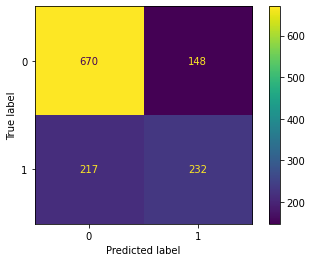


Classification report
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       818
           1       0.61      0.52      0.56       449

    accuracy                           0.71      1267
   macro avg       0.68      0.67      0.67      1267
weighted avg       0.70      0.71      0.71      1267




In [53]:
X1, y1 = load_ds_embedding('kerasEmb_text.txt')

clf = model_RNN()
clf.fit(X1[TRAIN], y1[TRAIN], epochs=10, validation_data=(X1[VAL], y1[VAL]), batch_size=500)
y_pred = clf.predict(X1[TEST])
show_result(y1[TEST], y_pred)

0it [00:00, ?it/s]

Accuracy
0.7182320441988951

F1_score
0.5208053691275167

Confusion_matrix


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


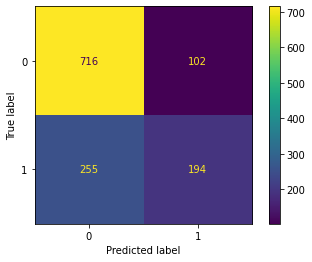


Classification report
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       818
           1       0.66      0.43      0.52       449

    accuracy                           0.72      1267
   macro avg       0.70      0.65      0.66      1267
weighted avg       0.71      0.72      0.70      1267




In [59]:
X1, y1 = load_ds_embedding('kerasEmb_text.txt')

clf2 = LinearSVC()
clf2.fit(X1[TRAIN], y1[TRAIN])
y_pred2 = clf2.predict(X1[TEST])
show_result(y1[TEST], y_pred2)

0it [00:00, ?it/s]

Accuracy
0.7079715864246251

F1_score
0.4903581267217631

Confusion_matrix


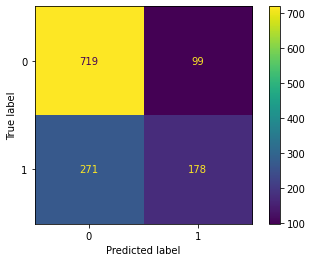


Classification report
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       818
           1       0.64      0.40      0.49       449

    accuracy                           0.71      1267
   macro avg       0.68      0.64      0.64      1267
weighted avg       0.70      0.71      0.69      1267




In [60]:
X1, y1 = load_ds_embedding('kerasEmb_text.txt')

clf3 = RandomForestClassifier(n_estimators=10)
clf3.fit(X1[TRAIN], y1[TRAIN])
y_pred3 = clf3.predict(X1[TEST])
show_result(y1[TEST], y_pred3)

0it [00:00, ?it/s]

Accuracy
0.6621941594317285

F1_score
0.5296703296703297

Confusion_matrix


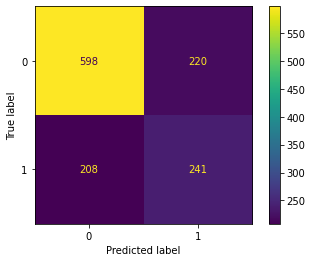


Classification report
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       818
           1       0.52      0.54      0.53       449

    accuracy                           0.66      1267
   macro avg       0.63      0.63      0.63      1267
weighted avg       0.66      0.66      0.66      1267




In [61]:
X1, y1 = load_ds_embedding('kerasEmb_text.txt')

clf4 = DecisionTreeClassifier()
clf4.fit(X1[TRAIN], y1[TRAIN])
y_pred4 = clf4.predict(X1[TEST])
show_result(y1[TEST], y_pred4)

0it [00:00, ?it/s]

Accuracy
0.6448303078137332

F1_score
0.004424778761061947

Confusion_matrix


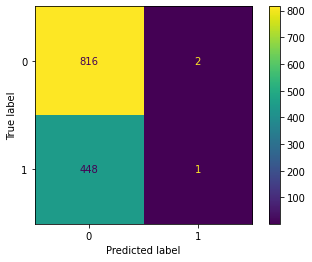


Classification report
              precision    recall  f1-score   support

           0       0.65      1.00      0.78       818
           1       0.33      0.00      0.00       449

    accuracy                           0.64      1267
   macro avg       0.49      0.50      0.39      1267
weighted avg       0.53      0.64      0.51      1267




In [62]:
X1, y1 = load_ds_embedding('kerasEmb_text.txt')

clf5 = GaussianNB()
clf5.fit(X1[TRAIN], y1[TRAIN])
y_pred5 = clf5.predict(X1[TEST])
show_result(y1[TEST], y_pred5)

0it [00:00, ?it/s]

Accuracy
0.7813733228097869

F1_score
0.6626065773447015

Confusion_matrix


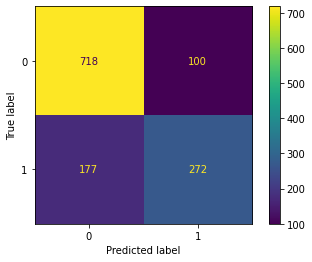


Classification report
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       818
           1       0.73      0.61      0.66       449

    accuracy                           0.78      1267
   macro avg       0.77      0.74      0.75      1267
weighted avg       0.78      0.78      0.78      1267




In [63]:
X1, y1 = load_ds_embedding('kerasEmb_text.txt')

clf6 = XGBClassifier()
clf6.fit(X1[TRAIN], y1[TRAIN])
y_pred6 = clf6.predict(X1[TEST])
show_result(y1[TEST], y_pred6)